# Tutorial - Variational Quantum Algorithms

## Exercise 1: Max 4-Cut

1. <u>Problem Definition</u>

The Max 4-Cut problem is defined on a graph $ G = (V, E) $, with a corresponding problem Hamiltonian given by:

$$
H_P = \sum_{e \in E} w_{e} H_{e},
$$

where $ w_e $ represents the weight of edge $ e \in E$, and $ H_e $ is the Hamiltonian associated with that edge.

2. <u>Generic Graph Problem</u>

In this exercise, the class `GraphProblem` from the `qaoa.problems` module is used to define the problem. The class requires two inputs:

1. A networkx graph $G$,
2. The number of qubits per vertex/node.

The `GraphProblem` class includes a method to create a quantum circuit for implementing the phase separating Hamiltonian $e^{-i\theta H_P}$. 

3. <u>Specific problem implementation</u>

However, `GraphProblem` relies on an abstract method, `create_edge_circuit`, which must be implemented to define the phase separating Hamiltonian $ H_e $ for an edge.


In [ ]:
import networkx as nx
import numpy as np

from qaoa.problems import GraphProblem

from qiskit import QuantumCircuit
from qiskit.circuit.library import PhaseGate

class Max4Cut(GraphProblem):
    def __init__(self, G: nx.Graph ) -> None:
        
        N_qubits_per_node = 2
        super().__init__(G, N_qubits_per_node)

        # each color is associated with a bitstring combination
        self.colors = {
            "color1": ["00"],
            "color2": ["01"],
            "color3": ["10"],
            "color4": ["11"],
        }
        # Create a dictionary to map each index to its corresponding set
        self.bitstring_to_color = {}
        for key, indices in self.colors.items():
            for index in indices:
                self.bitstring_to_color[index] = key

    def create_edge_circuit(self, theta):
        qc = QuantumCircuit(2 * self.N_qubits_per_node)

        " ---------------------"
        " implement the circuit"
        " ---------------------"
        
        return qc
    def create_edge_circuit_fixed_node(self, theta):
        pass

Show the circuit for one edge

Graph contains nodes with one or zero edges. These can be removed to reduce the size of the problem.


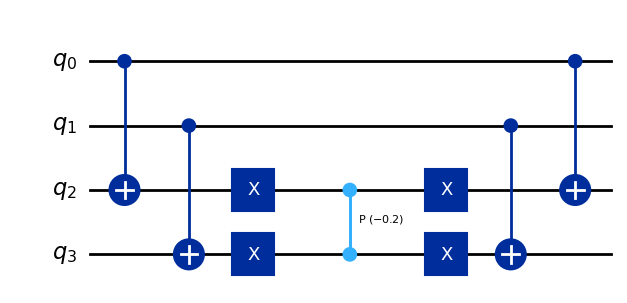

In [8]:
test = Max4Cut(nx.Graph([(0, 1, {"weight": 1.0})]))
test.create_edge_circuit(0.2).draw("mpl")

4. <u>Graph instance</u>

Let's start by defining a Graph with 10 nodes

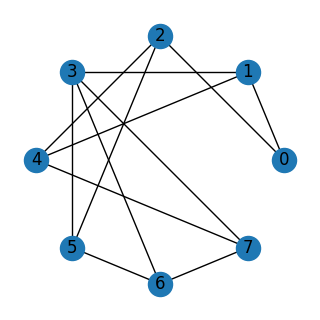

In [9]:
import matplotlib.pyplot as plt
# Create a graph with 8 nodes
G = nx.Graph()
# Add nodes
G.add_nodes_from(range(8))
# Add edges (example connections)
edges = [
    (0, 1), (0, 2), (1, 3), (1, 4), (2, 4), (2, 5),
    (3, 6), (4, 7), (5, 6), (6, 7), (7,3), (3,5)
]
G.add_edges_from(edges)

# Draw the graph
plt.figure(figsize=(3,3))
nx.draw(G, with_labels=True, pos = nx.circular_layout(G))

5. <u>Problem instance</u>

Now we can instantiate a Max4Cut problem with the graph and create and draw the resulting circuit for the phase separating Hamiltonian. Observe that there is one circuit per edge in the graph.

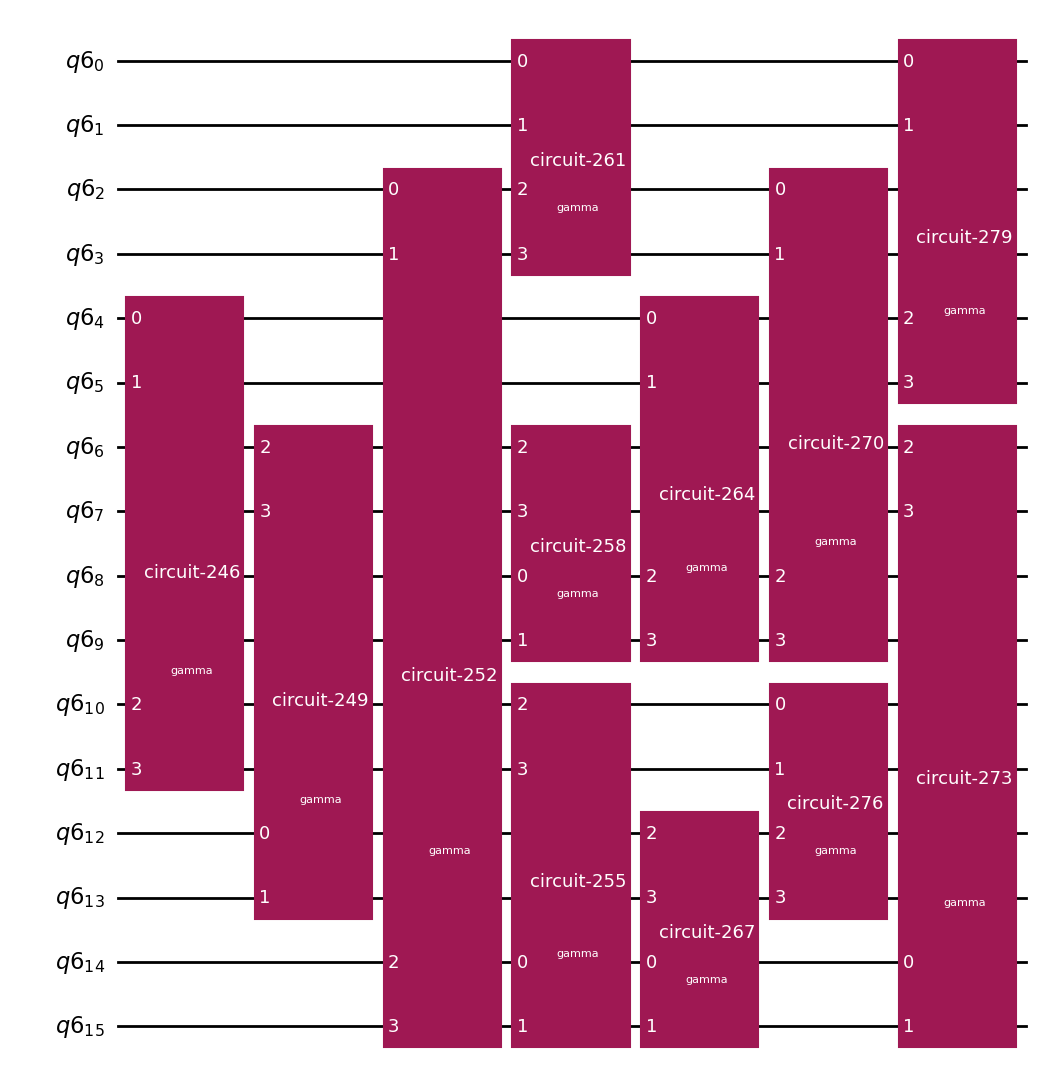

In [10]:
max4cut = Max4Cut(G)
max4cut.create_circuit()
max4cut.circuit.draw("mpl")

5. <u>QAOA instance</u>

We create a QAOA instance using
- as initial state we use the $\ket{+}$ state,
- as mixing operator the $X$-mixer, and
- as phase separation operator our newly created max4cut instance.

In [11]:
from qaoa import QAOA
from qaoa.initialstates import Plus
from qaoa.mixers import X
from qiskit_algorithms.optimizers import COBYLA

settings = {"maxiter": 100, "tol": 1e-3, "rhobeg": 0.1}
optimizer = [COBYLA, settings.copy()]

qaoa_k4 = QAOA(initialstate=Plus(), problem=max4cut, mixer=X(), optimizer=optimizer)

5. <u>Run QAOA</u>

- Sample the cost landscape and plot it.

2024-12-02 13:36:14 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
2024-12-02 13:36:15 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2024-12-02 13:36:15 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape
2024-12-02 13:36:15 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2024-12-02 13:36:22 [info     ] Done measurement               file=qaoa.qaoa func=sample_cost_landscape
2024-12-02 13:36:22 [info     ] Calculating Energy landscape done file=qaoa.qaoa func=sample_cost_landscape


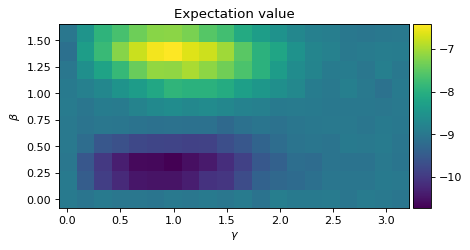

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_E(qaoa_instance, fig=None):
    angles = qaoa_instance.landscape_p1_angles
    dgamma = (qaoa_instance.gamma_grid[1]-qaoa_instance.gamma_grid[0])/2
    dbeta = (qaoa_instance.gamma_grid[1]-qaoa_instance.gamma_grid[0])/2
    extent = [
        angles["gamma"][0]-dgamma,
        angles["gamma"][1]+dgamma,
        angles["beta"][0]-dbeta,
        angles["beta"][1]+dbeta,
    ]
    return __plot_landscape(qaoa_instance.exp_landscape(), extent, fig=fig)

def __plot_landscape(A, extent, fig):
    if not fig:
        fig = plt.figure(figsize=(6, 6), dpi=80, facecolor="w", edgecolor="k")
    _ = plt.xlabel(r"$\gamma$")
    _ = plt.ylabel(r"$\beta$")
    ax = fig.gca()
    _ = plt.title("Expectation value")
    im = ax.imshow(A, interpolation="nearest", origin="lower", extent=extent)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    _ = plt.colorbar(im, cax=cax)

qaoa_k4.sample_cost_landscape( angles={"gamma": [0, np.pi, 20], "beta": [0, np.pi, 20]} )
plot_E(qaoa_k4)

- Use a local optimizer to find the optimum for $p=1$. We converge quickly to the local optimum.

2024-12-02 13:36:23 [info     ] cost(depth 1 = -10.727539062500002 file=qaoa.qaoa func=optimize


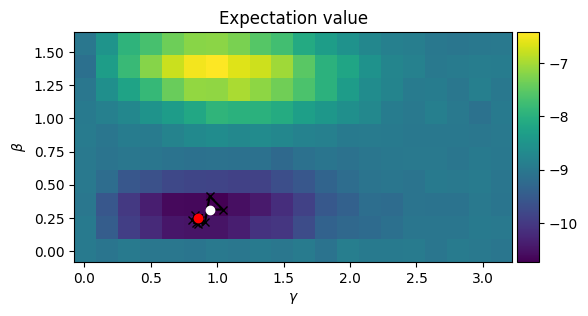

In [13]:
qaoa_k4.optimize(depth=1)

fig = plt.figure(figsize=(6, 6))
gamma = []
beta = []
angles = qaoa_k4.optimization_results[1].angles
for i in range(len(angles)):
    gamma.append(angles[i][0])
    beta.append(angles[i][1])
plt.plot(gamma, beta, "x-k")
plt.plot(gamma[0], beta[0], "wo")
plt.plot(gamma[-1], beta[-1], "or")
plot_E(qaoa_k4, fig=fig)

- Run QAOA up to depth $p=5$. We can see how the approximation ratio increases with $p$.

2024-12-02 13:36:25 [info     ] cost(depth 2 = -11.204101562499991 file=qaoa.qaoa func=optimize
2024-12-02 13:36:29 [info     ] cost(depth 3 = -11.468749999999988 file=qaoa.qaoa func=optimize
2024-12-02 13:36:34 [info     ] cost(depth 4 = -11.54296875    file=qaoa.qaoa func=optimize
2024-12-02 13:36:39 [info     ] cost(depth 5 = -11.604492187500007 file=qaoa.qaoa func=optimize


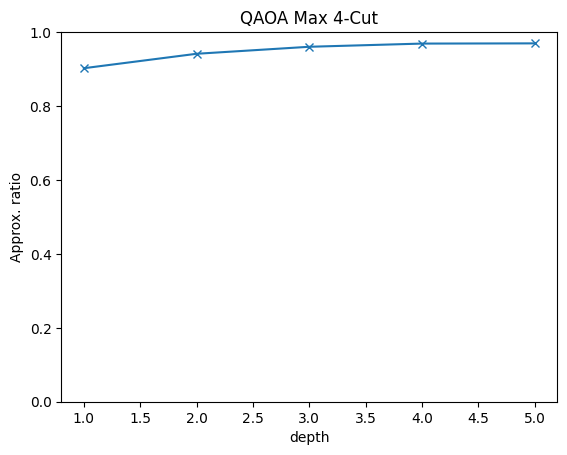

In [14]:
maxdepth = 5
qaoa_k4.optimize(depth=maxdepth)

p = np.arange(1, len(np.array(qaoa_k4.get_Exp())) + 1)
maxval=12
plt.plot(p, -np.array(qaoa_k4.get_Exp()) / maxval, marker="x")
plt.xlabel("depth")
plt.ylabel("Approx. ratio")
plt.title("QAOA Max 4-Cut")
plt.ylim([0, 1])
plt.show()

## Exercise 2: Max 3-Cut using the full Hilbert space

1. <u>Find the circuit with pen and paper</u>

Given $\operatorname{clr}^3_{< 3}$ we now want to devide the states into the following sets (containing power of two states),
- set one consist of $\ket{1011}, \ket{1110}$, and
- set two consists of $\ket{0000}, \ket{0101}, \ket{1010}, \ket{1111}, $.
  
Apply Theorem 1 from [[1]](#1) and work out what the circuit for an edge should look like, using pen and paper. 

Are there any gates that cancel?

2. <u>Specific problem implementation</ul>


In [15]:
class Max3CutFullH(GraphProblem):
    def __init__(self, G: nx.Graph ) -> None:

        N_qubits_per_node = 2
        super().__init__(G, N_qubits_per_node)

        self.colors = {
            "color1": ["00"],
            "color2": ["01"],
            "color3": ["10", "11"],
        }
        # Create a dictionary to map each index to its corresponding set
        self.bitstring_to_color = {}
        for key, indices in self.colors.items():
            for index in indices:
                self.bitstring_to_color[index] = key

    def create_edge_circuit(self, theta):
        qc = QuantumCircuit(2 * self.N_qubits_per_node)
        
        " ---------------------"
        " implement the circuit"
        " ---------------------"
        
        return qc

    def create_edge_circuit_fixed_node(self, theta):
        pass

Graph contains nodes with one or zero edges. These can be removed to reduce the size of the problem.


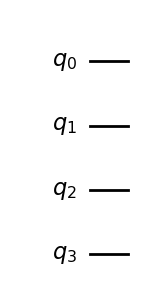

In [16]:
test = Max3CutFullH(nx.Graph([(0, 1, {"weight": 1.0})]))
test.create_edge_circuit(0.2).draw("mpl")

3. <u>Run QAOA</u>

In [17]:
qaoa_k3_fullH = QAOA(initialstate=Plus(), problem=Max3CutFullH(G), mixer=X(), optimizer=optimizer)

In [ ]:
qaoa_k3_fullH.optimize(depth=1, angles={"gamma": [0, np.pi, 20], "beta": [0, np.pi, 20]} )

fig = plt.figure(figsize=(6, 6))
gamma = []
beta = []
angles = qaoa_k3_fullH.optimization_results[1].angles
for i in range(len(angles)):
    gamma.append(angles[i][0])
    beta.append(angles[i][1])
plt.plot(gamma, beta, "x-k")
plt.plot(gamma[0], beta[0], "wo")
plt.plot(gamma[-1], beta[-1], "or")
plot_E(qaoa_k3_fullH, fig=fig)

2024-12-02 13:36:39 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape


IndexError: list index out of range

In [ ]:
maxdepth = 5
qaoa_k3_fullH.optimize(depth=maxdepth)

p = np.arange(1, len(np.array(qaoa_k3_fullH.get_Exp())) + 1)
maxval=12
plt.plot(p, -np.array(qaoa_k3_fullH.get_Exp()) / maxval, marker="x")
plt.xlabel("depth")
plt.ylabel("Approx. ratio")
plt.title("QAOA Max 3-Cut using the full Hilber space")
plt.ylim([0, 1])
plt.show()

## Exercise 3: Max 3-Cut using subspaces

1. <u>Show that the Grover mixer is valid using pen and paper</u>

$$
U_m(\beta) = e^{-i\beta \ket{F}\bra{F}}, \quad \text{where } U_S \ket{0} = \ket{F} := \frac{1}{\sqrt{|B|}} \sum_{x \in B} \ket{x}
$$

2. <u>Create circuit for Grover mixer</u>

Using the package `qaoa` create a Grover mixer for $\ket{ltk3} = \frac{\ket{00} + \ket{01} + \ket{11}}{\sqrt{3}}$. For this we import the following:


In [ ]:
from qaoa.initialstates import LessThanK

ltk3 = LessThanK(3)
ltk3.create_circuit()
ltk3.circuit.draw("mpl")

Create a circuit for $\ket{ltk3}^{\otimes 3}$. For this we can use the Tensor class.

In [ ]:
from qaoa.initialstates import Tensor

numNodes = 3
phi0 = Tensor(ltk3, numNodes)
phi0.create_circuit()
phi0.circuit.draw("mpl")

create the Grover mixer for $\ket{ltk3}^{\otimes 3}$

In [ ]:
from qaoa.mixers import Grover
grover =
" ---------------------"
" define the Grover mixer"
" ---------------------"

3. <u>Numerically test that the Grover mixer is valid</u>

Show that we have a valid mixer by plotting the overlap $\bra{z_1} U_M(\beta) \ket{z_2}$ depending on $\beta$:

- Pick two feasible computational basis states $\ket{z_1} \neq \ket{z_2}$ and see that the overlap is nonzero for some values of $\beta$
- Pick a feasible and an infeasible state, and show that the overlap is always zero

Let's start by importing the necessary things, before we can do some plots.

In [ ]:
import numpy as np
import matplotlib.pyplot as pl
from tqdm import tqdm
from qiskit_aer import Aer
from qiskit import (
    QuantumCircuit,
    QuantumRegister,
    ClassicalRegister,
    transpile,
)
backend=Aer.get_backend("qasm_simulator")

In [ ]:
overlap = []
betavalues = np.linspace(0,2*np.pi,50)
shots=10**5
for beta in tqdm(betavalues):
    q = QuantumRegister(numNodes*2)
    c = ClassicalRegister(numNodes*2)
    circuit = QuantumCircuit(q, c)
        " ---------------------"
        " implement a circuit for <z_1|"
        " ---------------------"
    circuit.barrier()
    circuit.append(grover.circuit, q)
    circuit.measure(q, c)
    circuit = transpile(circuit, backend)
    
    # Assign float values to the parameters
    parameters = list(circuit.parameters)
    parameter_values = [beta]
    bound_circuit = circuit.assign_parameters(dict(zip(parameters, parameter_values)))

    
    # Run the job
    job = backend.run(bound_circuit, shots=shots)
    counts = job.result().get_counts()
    overlap.append(counts.get(
        " ---------------------"
        " choose string for |z_2>"
        " ---------------------"
        ,0.)/shots)
    
# bound_circuit.draw('mpl')

pl.plot(betavalues, overlap)

4. <u>Problem class </u>

In [ ]:
class Max3Cut(GraphProblem):
    def __init__(self, G: nx.Graph ) -> None:
        
        N_qubits_per_node = 2
        super().__init__(G, N_qubits_per_node)

        # each color is associated with a bitstring combination
        self.colors = {
            "color1": ["00"],
            "color2": ["01"],
            "color3": ["10"],
        }
        # Create a dictionary to map each index to its corresponding set
        self.bitstring_to_color = {}
        for key, indices in self.colors.items():
            for index in indices:
                self.bitstring_to_color[index] = key

    def create_edge_circuit(self, theta):
        qc = QuantumCircuit(2 * self.N_qubits_per_node)

        qc.cx(0, 2)
        qc.cx(1, 3)
        qc.x([2, 3])
        phase_gate = PhaseGate(-theta).control(1)
        qc.append(phase_gate, [2, 3])
        qc.x([2, 3])
        qc.cx(1, 3)
        qc.cx(0, 2)
            
        return qc

        
    def create_edge_circuit_fixed_node(self, theta):
        # we will not use this function, so we can skip it
        pass

5. <u>Initial state class</u>

To run QAOA we need to implement the `InitialState` class that creates a Tensor of $\ket{ltk3}$ state, which can be done just as above


In [ ]:
from qaoa.initialstates import InitialState
class Max3CutInitialState(InitialState):
    
    def create_circuit(self) -> None:

        numQubitsPerNode = 2
        self.num_V = int(self.N_qubits/numQubitsPerNode)
        
        tg = 
        
        " ---------------------"
        " define the initial state"
        " ---------------------"
        
        tg.create_circuit()
        self.circuit = tg.circuit

6. <u>Mixer class</u>

We also need to implement the `Mixer` class that creates a Tensor of Grover mixer, which can be done just as above


In [ ]:
from qaoa.mixers import Mixer
class Max3CutGrover(Mixer):
        
    def create_circuit(self) -> None:

        numQubitsPerNode = 2
        self.num_V = int(self.N_qubits/numQubitsPerNode)
        
        gm = 
        
        " ---------------------"
        " define the Box Grover mixer"
        " ---------------------"
        
        gm.create_circuit()
        self.circuit = gm.circuit

7. <u>Run QAOA</u>

create an instance of QAOA and plot the resulting landscape

In [ ]:
qaoa_k3_subH = QAOA(
    initialstate=Max3CutInitialState(),
    problem=Max4Cut(G),
    mixer=Max3CutGrover(),
    optimizer=optimizer)

qaoa_k3_subH.optimize(depth=1, angles={"gamma": [0, 2*np.pi, 20], "beta": [0, 2*np.pi, 20]} )

fig = plt.figure(figsize=(6, 6))
gamma = []
beta = []
angles = qaoa_k3_subH.optimization_results[1].angles
for i in range(len(angles)):
    gamma.append(angles[i][0])
    beta.append(angles[i][1])
plt.plot(gamma, beta, "x-k")
plt.plot(gamma[0], beta[0], "wo")
plt.plot(gamma[-1], beta[-1], "or")
plot_E(qaoa_k3_subH, fig=fig)

8. <u>Comparison for MAX 3-CUT</u>

Compare the convergence for the method using the full Hilbert space and the subspace encoding up to d

In [ ]:
maxdepth = 5
qaoa_k3_subH.optimize(depth=maxdepth)

p = np.arange(1, len(np.array(qaoa_k3_subH.get_Exp())) + 1)
maxval=12
plt.plot(p, -np.array(qaoa_k3_fullH.get_Exp()) / maxval, marker="x", label="full H")
plt.plot(p, -np.array(qaoa_k3_subH.get_Exp()) / maxval, marker="x", label="sub H")
plt.xlabel("depth")
plt.ylabel("Approx. ratio")
plt.legend()
plt.title("QAOA Max 3-Cut comparison")
plt.ylim([0, 1])
plt.show()

For more info you can look into the following reference.

## References
<a id="1">[1]</a>
Fuchs, Franz G., Ruben P. Bassa, and Frida Lien.
"Encodings of the weighted MAX k-CUT on qubit systems."
Preprint arXiv 2024.
[arXiv:2411.08594](https://doi.org/10.48550/arXiv.2411.08594)

<a id="2">[2]</a>
Fuchs, Franz G., Ruben P. Bassa.
"LX-mixers for QAOA: Optimal mixers restricted to subspaces and the stabilizer formalism."
Quantum 8 (2024): 1535.
[10.22331/q-2024-11-25-1535](https://doi.org/10.22331/q-2024-11-25-1535)

<a id="3">[3]</a>
Bärtschi, Andreas, and Stephan Eidenbenz.
"Grover mixers for QAOA: Shifting complexity from mixer design to state preparation."
In 2020 IEEE International Conference on Quantum Computing and Engineering (QCE), pp. 72-82. IEEE, 2020.
[10.1109/QCE49297.2020.00020](https://doi.org/10.1109/QCE49297.2020.00020)